Flip image to get more training data (Aeffectilfe [..] without keypoints)


# Head pose estimation

Names: Javier Covas Llompart, Lukas Koberg

The goal is to develop a neural notwork, that is able to detect the pose of a head (the 3 angles). Therfor pytorch is used.

## Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision.models import resnet50, resnet152
from torchvision.transforms.functional import pil_to_tensor
from PIL import Image
import scipy.io as sio
import torchvision.transforms as T
import os
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#from google.colab import drive
#drive.mount('/content/gdrive/', force_remount=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [9]:
basepath = "Advanced Topics Computer Vision/Short Project/"

In [10]:
basepath = "Data/"

In [11]:
def compute_euler_angles_from_rotation_matrices(rotation_matrices, full_range=False):
    batch = rotation_matrices.shape[0]
    R = rotation_matrices
    sy = torch.sqrt(R[:,0,0]*R[:,0,0]+R[:,1,0]*R[:,1,0])
    singular = sy<1e-6
    singular = singular.float()

    '''2023.01.15'''
    for i in range(len(sy)):  # expand y (yaw angle) range into (-180, 180)
        if R[i, 0, 0] < 0 and full_range:
            sy[i] = -sy[i]

    x = torch.atan2(R[:,2,1], R[:,2,2])
    y = torch.atan2(-R[:,2,0], sy)
    z = torch.atan2(R[:,1,0],R[:,0,0])

    xs = torch.atan2(-R[:,1,2], R[:,1,1])
    ys = torch.atan2(-R[:,2,0], sy)
    zs = R[:,1,0]*0

    gpu = rotation_matrices.get_device()
    if gpu < 0:
        out_euler = torch.autograd.Variable(torch.zeros(batch,3)).to(torch.device('cpu'))
    else:
        out_euler = torch.autograd.Variable(torch.zeros(batch,3)).to(torch.device('cuda:%d' % gpu))
    out_euler[:,0] = x*(1-singular)+xs*singular
    out_euler[:,1] = y*(1-singular)+ys*singular
    out_euler[:,2] = z*(1-singular)+zs*singular
    # print('out_euler', out_euler)

    return out_euler

## Load Datasets and Preperation

In [12]:
class BIWI_Dataset(Dataset):
    def __init__(self): #Example code
        # convert into PyTorch tensors and remember them
        
        self.X = self.read_data()[0]
        self.y = self.read_data()[1]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, train_size=0.7, shuffle=True)

    def __len__(self):
        # this should return the size of the dataset
        return len(self.X_train)

    def __getitem__(self, idx):
        # this should return one sample from the dataset
        #features = pil_to_tensor(Image.open(self.X[idx])).float()
        target_height = 100
        img = Image.open(self.X_train[idx])
        width, height = img.size
        new_width = int(width * (target_height / height))
        img = img.resize((new_width, target_height))
        features = self.transform(img)
        target = self.y_train[idx, 1].unsqueeze(0)
        return features, target
    
    def get_test_item(self, idx):
        # this should return one sample from the dataset
        #features = pil_to_tensor(Image.open(self.X[idx])).float()
        target_height = 50
        img = Image.open(self.X_test[idx])
        width, height = img.size
        new_width = int(width * (target_height / height))
        features = self.transform(img)
        target = self.y_test[idx, 1]
        return features, target
    
    transform = T.Compose([
        #T.ToPILImage(),
        #T.Resize(([64, 49])),
        T.ToTensor()])
    
    def read_data(self):
        list_angle_data = []
        list_picture_data = []

        #folder_nr = "01"
        for i in range(1, 25):
            if i <10:
                folder_nr = "0" + str(i)
            else:
                folder_nr = str(i)
            for file in os.listdir(basepath + "BIWI/" + folder_nr):
                if file.endswith(".png"):
                    list_picture_data.append(basepath + "BIWI/" + folder_nr + "/" + file)
                    f = open(basepath + "BIWI/" + folder_nr + "/frame_" + file.split("_")[1] + "_pose.txt", "r")
                    file_data = f.read()
                    file_data_split = file_data.split()
                    matrix = np.array(file_data_split[0:9], dtype=np.float32).reshape(3, 3)
                    list_angle_data.append(matrix)
        #print((np.stack(list_angle_data, axis=0).shape))
        angles = compute_euler_angles_from_rotation_matrices(torch.tensor(np.stack(list_angle_data, axis=0), dtype=torch.float32))
        #print(angles*180/np.pi)
        return list_picture_data, angles


In [13]:
dataset = BIWI_Dataset()
print(dataset.__getitem__(11))
#plt.hist(dataset.y)

(tensor([[[0.6157, 0.7529, 0.7529,  ..., 0.5020, 0.5020, 0.4118],
         [0.7804, 0.9569, 0.9608,  ..., 0.6078, 0.6118, 0.5020],
         [0.8275, 0.9961, 0.9961,  ..., 0.6039, 0.6039, 0.4980],
         ...,
         [0.0078, 0.0471, 0.1412,  ..., 0.0431, 0.2941, 0.4353],
         [0.0196, 0.1020, 0.1647,  ..., 0.0471, 0.3020, 0.4392],
         [0.0275, 0.0980, 0.1333,  ..., 0.0431, 0.2549, 0.3608]],

        [[0.6118, 0.7490, 0.7451,  ..., 0.4784, 0.4824, 0.3882],
         [0.7765, 0.9529, 0.9529,  ..., 0.5882, 0.5882, 0.4745],
         [0.8275, 0.9961, 0.9961,  ..., 0.5804, 0.5843, 0.4706],
         ...,
         [0.0078, 0.0314, 0.0863,  ..., 0.0588, 0.3255, 0.4196],
         [0.0118, 0.0627, 0.0902,  ..., 0.0706, 0.3490, 0.4157],
         [0.0196, 0.0627, 0.0784,  ..., 0.0510, 0.3020, 0.3373]],

        [[0.6196, 0.7608, 0.7569,  ..., 0.4431, 0.4627, 0.3765],
         [0.7843, 0.9608, 0.9608,  ..., 0.5569, 0.5725, 0.4627],
         [0.8275, 0.9961, 0.9922,  ..., 0.5569, 0.5686, 0

(array([  92.,  278.,  645., 1282., 3006., 2396., 1403., 1005.,  536.,
         331.]),
 array([-1.44111383, -1.20354509, -0.96597642, -0.72840774, -0.49083906,
        -0.25327036, -0.01570166,  0.22186702,  0.45943573,  0.69700444,
         0.93457311]),
 <BarContainer object of 10 artists>)

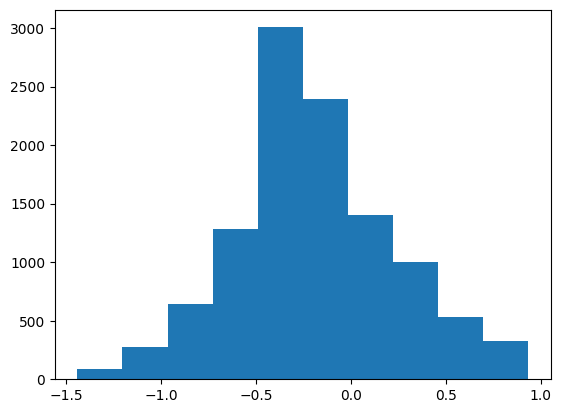

In [18]:
plt.hist(dataset.y_train[:,0])

torch.Size([100, 133, 3])


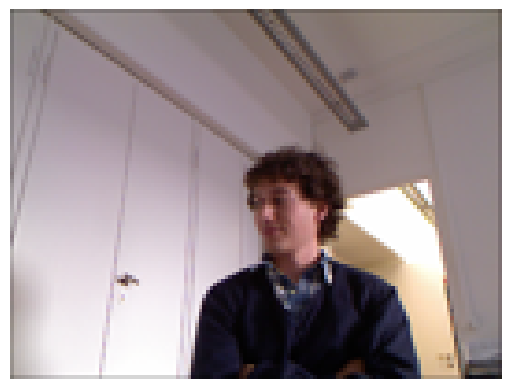

In [25]:
reshaped_image = dataset.__getitem__(0)[0].permute(1, 2, 0)
print(reshaped_image.shape)
# Display the image using plt.imshow
plt.imshow(reshaped_image)
plt.axis('off')  # Hide axes
plt.show()

In [26]:
len(dataset.X_train)

10974

## Model

- Oroginal paper based on RESNET!

In [27]:
resnet152_model = resnet152(pretrained=False)
class HeadPoseModel_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet152_model = resnet152_model
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1000, 1000)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(1000, 1000)
        self.act2 = nn.ReLU()
        self.linear3 = nn.Linear(1000, 500)
        self.act3 = nn.ReLU()
        self.linear4 = nn.Linear(500, 1)

    def forward(self, x):
      x = self.resnet152_model(x)
      x = self.flatten(x)
      x = self.act1(self.linear1(x))
      x = self.act2(self.linear2(x))
      x = self.act3(self.linear3(x))
      x = self.linear4(x)
      return x

model = HeadPoseModel_1()
#print(model)
summary(model,(3,300,300))


e:\Programme\.conda\envs\CV_Head\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\Programme\.conda\envs\CV_Head\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1000]                --
|    └─Conv2d: 2-1                       [-1, 64, 150, 150]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 150, 150]        128
|    └─ReLU: 2-3                         [-1, 64, 150, 150]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 75, 75]          --
|    └─Sequential: 2-5                   [-1, 256, 75, 75]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 75, 75]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 75, 75]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 75, 75]         70,400
|    └─Sequential: 2-6                   [-1, 512, 38, 38]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 38, 38]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 38, 38]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 38, 38] 

Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1000]                --
|    └─Conv2d: 2-1                       [-1, 64, 150, 150]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 150, 150]        128
|    └─ReLU: 2-3                         [-1, 64, 150, 150]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 75, 75]          --
|    └─Sequential: 2-5                   [-1, 256, 75, 75]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 75, 75]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 75, 75]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 75, 75]         70,400
|    └─Sequential: 2-6                   [-1, 512, 38, 38]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 38, 38]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 38, 38]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 38, 38] 

## Train Models

In [28]:
# set up DataLoader for training set
dataset = BIWI_Dataset()
loader = DataLoader(dataset, shuffle=True, batch_size=100)

In [29]:
loss_fn = nn.MSELoss()  # Mean squered error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
n_epochs = 5
save_mode_path = "Models/model_1/model_checkpoint.pth"
model.train()
for epoch in range(n_epochs):
    for X_batch, y_batch in loader:
        #step = (epoch * len(loader)) + i + 1
        y_pred = model(X_batch)
        print(y_pred.shape)
        print(y_batch.shape)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Save the model's state_dict every 1000 steps
        #if step % 1000 == 0:
        #   pass
            #save_mode_path = "Models/model_1/model_checkpoint.pth"
            #torch.save(model.state_dict(), save_mode_path)
        print(f'latest loss {loss}')
    #print(f'{epoch}, step: {step}, latest loss {loss}')
    torch.save(model.state_dict(), save_mode_path)
    print(f'Finished epoch {epoch}, latest loss {loss}')

#save_mode_path = "Models/model_1/model_checkpoint.pth"
torch.save(model.state_dict(), save_mode_path)


torch.Size([100, 1])
torch.Size([100, 1])
latest loss 0.23586219549179077
torch.Size([100, 1])
torch.Size([100, 1])
latest loss 14.796905517578125
torch.Size([100, 1])
torch.Size([100, 1])
latest loss 0.16134314239025116
torch.Size([100, 1])
torch.Size([100, 1])
latest loss 0.26758483052253723
torch.Size([100, 1])
torch.Size([100, 1])
latest loss 0.530124306678772
torch.Size([100, 1])
torch.Size([100, 1])
latest loss 0.28793713450431824
torch.Size([100, 1])
torch.Size([100, 1])
latest loss 0.2015015035867691
torch.Size([100, 1])
torch.Size([100, 1])
latest loss 0.16012805700302124
torch.Size([100, 1])
torch.Size([100, 1])
latest loss 0.19105692207813263
torch.Size([100, 1])
torch.Size([100, 1])
latest loss 0.22494813799858093
torch.Size([100, 1])
torch.Size([100, 1])
latest loss 0.2036169022321701
torch.Size([100, 1])
torch.Size([100, 1])
latest loss 0.253085732460022
torch.Size([100, 1])
torch.Size([100, 1])
latest loss 0.2954288423061371
torch.Size([100, 1])
torch.Size([100, 1])
late

### Load model

In [8]:
# Initialize the model
model = HeadPoseModel_1()
# Load the saved state_dict
save_mode_path = "Models/model_1/model_checkpoint.pth"

model.load_state_dict(torch.load(save_mode_path))
# Set the model to evaluation mode
model.eval()

HeadPoseModel_1(
  (resnet152_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

## Evaluate Model

In [31]:
for i in range(0,100):
    y_pred = model(dataset.get_test_item(i)[0].unsqueeze(0))
    y_test =  dataset.get_test_item(i)[1].unsqueeze(0)
    acc = (y_pred.round() == y_test).float().mean()
    acc = float(acc)
    print("Model accuracy: %.2f%%" % (acc*100))
    print(f"{y_pred} truth: {y_test}")

Model accuracy: 0.00%
tensor([[-0.3090]], grad_fn=<AddmmBackward0>) truth: tensor([0.0761])
Model accuracy: 0.00%
tensor([[-0.3225]], grad_fn=<AddmmBackward0>) truth: tensor([-0.6072])
Model accuracy: 0.00%
tensor([[-0.3079]], grad_fn=<AddmmBackward0>) truth: tensor([-0.3001])
Model accuracy: 0.00%
tensor([[-0.3107]], grad_fn=<AddmmBackward0>) truth: tensor([0.0456])
Model accuracy: 0.00%
tensor([[-0.3193]], grad_fn=<AddmmBackward0>) truth: tensor([-0.1878])
Model accuracy: 0.00%
tensor([[-0.3172]], grad_fn=<AddmmBackward0>) truth: tensor([-0.4286])
Model accuracy: 0.00%
tensor([[-0.3074]], grad_fn=<AddmmBackward0>) truth: tensor([-0.4872])
Model accuracy: 0.00%
tensor([[-0.3300]], grad_fn=<AddmmBackward0>) truth: tensor([-0.8886])
Model accuracy: 0.00%
tensor([[-0.3119]], grad_fn=<AddmmBackward0>) truth: tensor([0.2211])
Model accuracy: 0.00%
tensor([[-0.3142]], grad_fn=<AddmmBackward0>) truth: tensor([-0.4044])
Model accuracy: 0.00%
tensor([[-0.3054]], grad_fn=<AddmmBackward0>) truth

KeyboardInterrupt: 